# Tensor Pipeline

This note book runs the  lsr structured tensor ridge regression model with the following parameters fixed.

1. Ridge regression coefficient: 
2. Max iterations
3. Separation Rank
4. Tucker Rank



## Install Libraries

In [1]:
%pip install dill

Note: you may need to restart the kernel to use updated packages.


## System Path

In [2]:
import sys
import platform

# Check the operating system
if platform.system() == "Windows":
    # Using double backslashes
    sys.path.append(r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Closed_Form_Solver\Code Files")
elif platform.system() == "Darwin":  # macOS
    # Append path for macOS
    sys.path.append("Your path for macOS")

## Import Libraries

In [3]:
#Import sklearn stuff
import datetime
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy


#Used to load data from pkl file
import dill

#Import External Files
from KFoldCV import KFoldCV
from train_test import train_test
from DataGenerationB import *

## Import Data

In [4]:
import platform
import numpy as np

### FMRI

if platform.system() == "Windows": 
    file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\fmri_rs.npy"
elif platform.system() == "Darwin":
    file_path = r"../Data/fmri_rs.npy"  # Adjust the path for macOS

with open(file_path, "rb") as f:
    fmri_rs = np.load(f)
    
    
### dMRI
#loading data

if platform.system() == 'Windows':
    file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Diffusion MRI\features_schaefer_streamcount_log.mat"
elif platform.system() == 'Darwin':
    file_path = 'add the path'

dMRI_streamlog = (scipy.io.loadmat(file_path)['features_schaefer_streamcount_log'])

# Each sample is a row
fmri_rs = fmri_rs.T
dMRI_streamlog = dMRI_streamlog.T


# Determine the platform and load the appropriate file
if platform.system() == "Windows": 
    mat_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_60_splits.mat"
elif platform.system() == "Darwin":
    mat_file_path = "../Data/MMP_HCP_60_splits.mat"
else:
    raise ValueError("Unsupported platform")

# Load the .mat file
mat_file = scipy.io.loadmat(mat_file_path)

# Extract subject lists from the loaded file
seed_1 = mat_file['folds']['seed_1'][0, 0]
subject_lists = seed_1['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0, 0].flatten()]

#Getting the HCP test subjects 

#array to hold the  subjects
HCP_753_Subjects = []
#file path
file_path = ''
#setting the file path
if platform.system() == "Windows":
    file_path = r'D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_753_subs.txt'
elif platform.system() == "Darwin":
    file_path = '../Data/MMP_HCP_753_subs.txt'
#if file pat  h is returned then load
if file_path:
    try:
        with open(file_path, 'r') as file:
            HCP_753_Subjects = [int(line.strip()) for line in file.readlines()]
    except Exception as e:
        print(f"An error occurred: {e}")


#Put the HCP test subjects into a dataframe
# Determine the platform and load the appropriate file
if platform.system() == "Windows":
    csv_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_componentscores.csv"
elif platform.system() == "Darwin":
    csv_file_path = "../Data/MMP_HCP_componentscores.csv"

df = pd.read_csv(csv_file_path)
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

#Create train and test arrays
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape labels into column vector

#Functional Connectivity Matrices

X_train_vec_fmri, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test_vec_fmri, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

#Structural Connectivity

X_train_vec_dmri = dMRI_streamlog[train_subjects]
X_test_vec_dmri = dMRI_streamlog[test_subjects]


### Standardizing each 

In [5]:
# scalers
scaler_fmri = StandardScaler()
scaler_dmri = StandardScaler() 

#fmri

X_train_vec_fmri_std = scaler_fmri.fit_transform(X_train_vec_fmri)
X_test_vec_fmri_std = scaler_fmri.transform(X_test_vec_fmri)

#dmri

X_train_vec_dmri_std = scaler_dmri.fit_transform(X_train_vec_dmri)
X_test_vec_dmri_std = scaler_dmri.transform(X_test_vec_dmri)

print(f"norm_mean_fmri:{np.linalg.norm(scaler_fmri.mean_)} | variance: {np.linalg.norm(scaler_fmri.var_)}")
print(f"norm_mean_fmri:{np.linalg.norm(scaler_dmri.mean_)} | variance: {np.linalg.norm(scaler_dmri.var_)}")

norm_mean_fmri:32.03230559687168 | variance: 2.14092718165562
norm_mean_fmri:464.23670009315447 | variance: 194.81840066698228


## Conversion: FC-Vectors, SC-Vectors --> Merged Matrices

In [6]:
#conversion of the HCP data from Vector --> Matrix

def merging_modalities(vector1,vector2,outputdim): 
    
    '''
    This code take vector1 and vector2 of same length as the input and reconstructed the matrix with the vector1 element as the
    upper triangle and the vector 2 elements as the lower triangle.
    '''
    
    #checking whether we can generate the symmetric matrix 
    vector1_length = vector1.shape[0]
    vector2_length = vector2.shape[0]
    desired_length = outputdim * (outputdim - 1) / 2
    
    if vector1_length != vector2_length:
        raise ValueError("Vector length mismatch.")
    elif vector1_length != desired_length:
        raise ValueError("Vector length is insufficient to construct the symmetric matrix.")

    #matrix_1
    
    matrix_1 = np.zeros((outputdim, outputdim))
    
    #counter for the vector 
    q = 0
    
    for i in range (outputdim):
        for j in range(i,outputdim):
            if i == j:
                matrix_1[i,j] = 1
            else:
                matrix_1[i,j] = vector1[q]
                q = q+1 
    
    
    #matrix 2
    
    matrix_2 = np.zeros((outputdim, outputdim))
    
    #counter for the vector 
    p = 0
    
    for i in range (outputdim):
        for j in range(i,outputdim):
            if i == j:
                matrix_2[i,j] = 1
            else:
                matrix_2[i,j] = vector2[p]
                p = p+1 
                
    #upper and lower triangle 
    upper_triangle = matrix_1
    lower_triangle = matrix_2.T
    
    #constructing the matrix
    matrix_eye = np.eye(outputdim)
    matrix =  upper_triangle + lower_triangle - matrix_eye
    
    return matrix

def samplestomat(dataset1,dataset2,outputdim):
    
    '''
    This code is developed to convert the vectorized data matrix in to a 3D data tensor.
    
    dataset : nd:array - (samples*features)
    outputdim : scalar

    '''

    #number of samples
    n_samples = dataset1.shape[0]
    #3D matrix to hold the output
    out_dataset = np.zeros((n_samples,outputdim,outputdim))

    for p in range(n_samples):
        
        vector_1 = dataset1[p]
        vector_2 = dataset2[p] 
        sample = merging_modalities(vector_1,vector_2,outputdim)
        out_dataset[p] = sample

    random_index = np.random.randint(0, n_samples)
    random_sample = out_dataset[random_index]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(random_sample, cmap='viridis', cbar=True)
    plt.title(f'Heatmap of Random Sample {random_index}')
    plt.show()

    return out_dataset
        


     

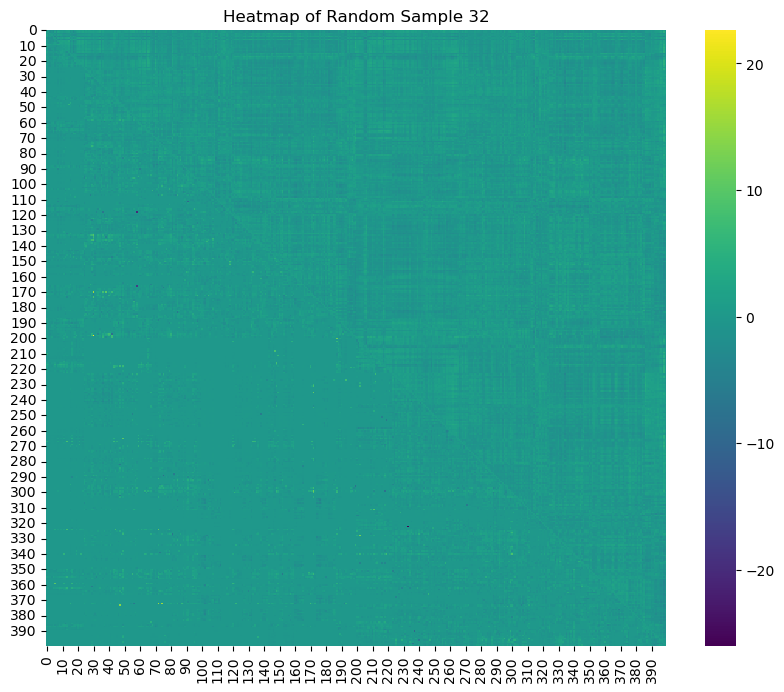

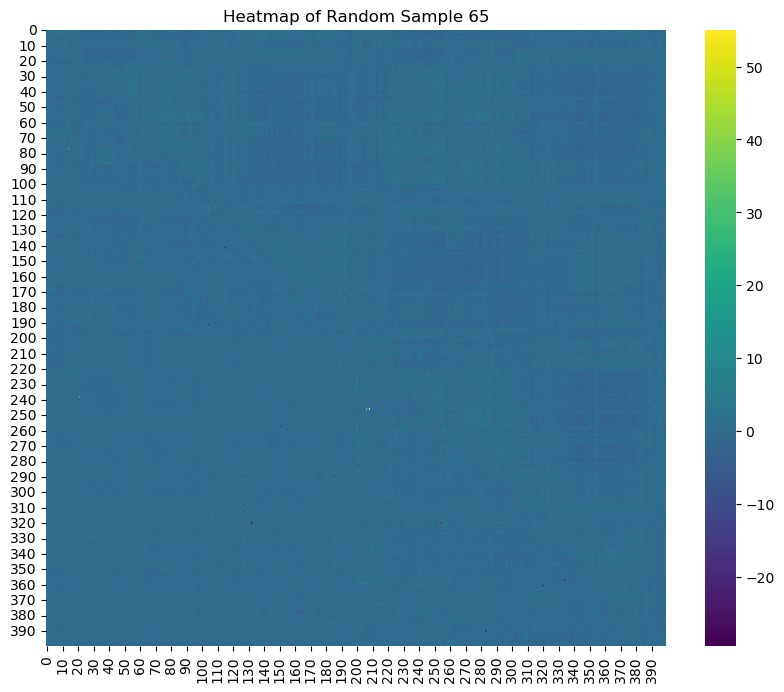

(677, 400, 400)
(677,)
(76, 400, 400)
(76,)


In [7]:
#Training data
X_train = samplestomat(X_train_vec_fmri_std,X_train_vec_dmri_std,400)
X_test  = samplestomat(X_test_vec_fmri_std,X_test_vec_dmri_std,400)
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


##  Preprocessing 

### Cosine Similarity



In [8]:
#Function to row wise normalization of samples

# normalizing using frobenious norm

def normalize_by_frobenius_norm(samples):
    """
    Normalizes each sample (2D matrix) in the array by its Frobenius norm.

    Parameters:
    samples (numpy.ndarray): A 3D numpy array with dimensions [samples, rows, columns].

    Returns:
    numpy.ndarray: A 3D numpy array with each sample normalized by its Frobenius norm.
    """
    # Calculate the Frobenius norm for each sample
    frobenius_norms = np.linalg.norm(samples, axis=(1, 2))
    
    # Reshape the norms to broadcast correctly for division
    frobenius_norms = frobenius_norms[:, np.newaxis, np.newaxis]
    
    # Normalize each sample by its Frobenius norm
    normalized_samples = samples / frobenius_norms
    
    return normalized_samples

#Function to row wise normalizati

X_train = normalize_by_frobenius_norm(X_train)
X_test = normalize_by_frobenius_norm(X_test)

### Removing intercept

In [9]:
#number of samples in train and test 
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)

X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)

# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, X_train.shape[1],X_train.shape[2])
X_test  = X_test_scaled.reshape(n_test, X_test.shape[1],X_train.shape[2])

#average response value
Y_train_mean = np.mean(Y_train)
# Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)




Sample mean for each feature (across samples): [ 2.71262224e-03 -8.92493066e-05 -8.24695226e-05 ...  5.82803849e-06
  2.82235680e-07  2.71262224e-03]
Sample variance for each feature (across samples): None
Response Average: 1.127096656182391


## Hyper Parameters

In [10]:
tensor_dimensions = np.array([X_train.shape[1], X_train.shape[2]])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2

#For now, define finite alpha set that we are searching over
alphas =  [0,0.5,1,10,20,30,40,50,100,150,180]
#[0, 0.00001, 0.0001, 0.001, 0.004, 0.007, 0.01, 0.04, 0.07, 0.1, 0.4, 0.7, 1, 1.5, 2, 2.5, 3,3.5, 4, 5, 10, 15, 20]
#0,0.5,1,10,20,30,40,50,100,150,180
#searching around 180
#176,178,180,182,184



## KFoldCV if we nee to run KFold cross validation 

In [11]:
#Define Number of Folds we want
k_folds = 5
hypers = {'max_iter': 50, 'threshold': 1e-7, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information,gradient_information = KFoldCV(X_train, Y_train, alphas, k_folds, hypers, B_tensored = None, intercept= False)

intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is n

c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 0, Alpha = 40, NMSE: 1.0, Correlation: nan, R^2 Score: -0.013490012237499682


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 0, Alpha = 50, NMSE: 1.0, Correlation: nan, R^2 Score: -0.013490012237499682


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 0, Alpha = 100, NMSE: 1.0, Correlation: nan, R^2 Score: -0.013490012237499682


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 0, Alpha = 150, NMSE: 1.0, Correlation: nan, R^2 Score: -0.013490012237499682


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 0, Alpha = 180, NMSE: 1.0, Correlation: nan, R^2 Score: -0.013490012237499682


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold = 1, Alpha = 0, NMSE: 2.8050498833644943, Correlation: 0.3375743164682487, R^2 Score: -1.824207884792958
Fold = 1, Alpha = 0.5, NMSE: 0.9784897155608051, Correlation: 0.47446488103832346, R^2 Score: 0.014827370356409908
Fold = 1, Alpha = 1, NMSE: 1.2752647305940654, Correlation: 0.3562468243843739, R^2 Score: -0.2839745662641129
Fold = 1, Alpha = 10, NMSE: 0.8676545313738826, Correlation: 0.4686280545741802, R^2 Score: 0.12641953951874052
Fold = 1, Alpha = 20, NMSE: 0.7567037461400422, Correlation: 0.4900788387346215, R^2 Score: 0.2381280992629755
Fold = 1, Alpha = 30, NMSE: 0.8755929953329481, Correlation: 0.3656631841033771, R^2 Score: 0.11842685723551272
stopping_criterion_reached
Fold = 1, Alpha = 40, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006829825573541948


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 1, Alpha = 50, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006829825573541948


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 1, Alpha = 100, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006829825573541948


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 1, Alpha = 150, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006829825573541948


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 1, Alpha = 180, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006829825573541948


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold = 2, Alpha = 0, NMSE: 3.4391836063035077, Correlation: 0.178630218374363, R^2 Score: -2.6100379566159577
Fold = 2, Alpha = 0.5, NMSE: 1.1276114986855867, Correlation: 0.3937018026432088, R^2 Score: -0.1836298309606248
Fold = 2, Alpha = 1, NMSE: 1.1710719004548216, Correlation: 0.4077814216962659, R^2 Score: -0.22924929126194593
Fold = 2, Alpha = 10, NMSE: 0.7988746629207818, Correlation: 0.5038144691441983, R^2 Score: 0.1614382406228848
Fold = 2, Alpha = 20, NMSE: 0.6715625536506842, Correlation: 0.5630301934360955, R^2 Score: 0.29507505662756395
stopping_criterion_reached
Fold = 2, Alpha = 30, NMSE: 1.0, Correlation: nan, R^2 Score: -0.049678752247859004


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 2, Alpha = 40, NMSE: 1.0, Correlation: nan, R^2 Score: -0.049678752247859004


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 2, Alpha = 50, NMSE: 1.0, Correlation: nan, R^2 Score: -0.049678752247859004


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 2, Alpha = 100, NMSE: 1.0, Correlation: nan, R^2 Score: -0.049678752247859004


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 2, Alpha = 150, NMSE: 1.0, Correlation: nan, R^2 Score: -0.049678752247859004


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 2, Alpha = 180, NMSE: 1.0, Correlation: nan, R^2 Score: -0.049678752247859004


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold = 3, Alpha = 0, NMSE: 7.101147723757129, Correlation: 0.12356478919154376, R^2 Score: -6.142025289390268
Fold = 3, Alpha = 0.5, NMSE: 0.9734177270007042, Correlation: 0.5010571068889907, R^2 Score: 0.020978820068608295
Fold = 3, Alpha = 1, NMSE: 1.0513798494296984, Correlation: 0.4301528553636918, R^2 Score: -0.05743208921857623
Fold = 3, Alpha = 10, NMSE: 0.7272813748151868, Correlation: 0.5556226798773394, R^2 Score: 0.2685320495368646
Fold = 3, Alpha = 20, NMSE: 0.7092683963367952, Correlation: 0.5399448704440112, R^2 Score: 0.2866487192407655
stopping_criterion_reached
Fold = 3, Alpha = 30, NMSE: 1.0, Correlation: nan, R^2 Score: -0.005756473069329582


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 3, Alpha = 40, NMSE: 1.0, Correlation: nan, R^2 Score: -0.005756473069329582


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 3, Alpha = 50, NMSE: 1.0, Correlation: nan, R^2 Score: -0.005756473069329582


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 3, Alpha = 100, NMSE: 1.0, Correlation: nan, R^2 Score: -0.005756473069329582


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 3, Alpha = 150, NMSE: 1.0, Correlation: nan, R^2 Score: -0.005756473069329582


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 3, Alpha = 180, NMSE: 1.0, Correlation: nan, R^2 Score: -0.005756473069329582


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold = 4, Alpha = 0, NMSE: 6.668033277277124, Correlation: 0.10392329776465689, R^2 Score: -5.714334046092942
Fold = 4, Alpha = 0.5, NMSE: 1.0327331618540267, Correlation: 0.4076749285235676, R^2 Score: -0.039904142769550566
Fold = 4, Alpha = 1, NMSE: 0.9542380067160062, Correlation: 0.4038936185262071, R^2 Score: 0.03913605854326818
Fold = 4, Alpha = 10, NMSE: 1.1485282460871784, Correlation: 0.19398454464585035, R^2 Score: -0.15650327239392103
Fold = 4, Alpha = 20, NMSE: 0.8567436581329467, Correlation: 0.3822315824792281, R^2 Score: 0.13730737784721114
Fold = 4, Alpha = 30, NMSE: 0.9010400321597561, Correlation: 0.3119148850789798, R^2 Score: 0.09270342344581317
stopping_criterion_reached
Fold = 4, Alpha = 40, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006943691923913864


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 4, Alpha = 50, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006943691923913864


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 4, Alpha = 100, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006943691923913864


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 4, Alpha = 150, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006943691923913864


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


stopping_criterion_reached
Fold = 4, Alpha = 180, NMSE: 1.0, Correlation: nan, R^2 Score: -0.006943691923913864


c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Train + Test Block

In [18]:
hypers = {'max_iter': 50, 'threshold': 1e-7, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
test_normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_level_values,iterate_level_reconstructed_tensor = train_test(X_train, Y_train, X_test, Y_test, lambda1, hypers,Y_train_mean, B_tensored = None, intercept= False)

intercept is not initialized
Y_test_predicted: [ 1.21297277  1.37568325 -0.03470827  0.39107491 -0.05654985 -0.21759299
 -0.31550358  2.12120858  1.4793834   0.22387833  1.82152781  0.67961745
  0.32105548  1.34232854 -0.14326785  1.49596842  2.03515551  2.48049654
  0.26401681  1.10027923  2.12165868  1.83843488  0.64957537  0.87678978
  1.40195521  1.2928848   1.10845718  0.81238949  1.99217833  2.14701266
  1.37344264  0.59911629 -0.86921264  2.19719703  0.88154775  1.07650884
  0.95553176  0.0170815   1.08283752 -0.57593494  0.08740846  0.65867405
  2.568762   -0.83394948  1.26922848  2.60115621  0.3003621   3.44450469
  1.06686863  2.34511796  1.57135873 -0.0624498   2.158061   -1.1024673
  2.15123334  0.59494529  2.11921049  1.08220308  0.66257602  1.00705538
  1.81455386  0.06807393  2.61519845  1.96062803  1.6566491   2.28869086
  1.49610143  0.37990528  1.81575963  0.07031999  0.86366788  0.55783101
  0.88502049  0.05824898 -0.17246247  0.30638355], Y_test: [ 1.49770661  1.924

## Save Results

In [19]:
#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']

if platform.system() == "Windows":
    pkl_file = rf"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression_All_Data\Closed_Form_Solver\Multimodal\LSR\Frobenious\HCP_lambdas_{alphas}_sep_{separation_rank}_tucker_{tensor_mode_ranks}.pkl"
elif platform.system() == "Darwin":
    pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Stochastic LSR TRR/Experimental Results/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"


In [14]:
print("Error Record on Training _ After K-Fold CV")
print("Validation Normalized Estimation Error: ", validation_normalized_estimation_error)
print("Validation NMSE Losses: ", validation_nmse_losses)
print("Validation Correlations: ", validation_correlations)
print("Validation R2 Scores: ", validation_R2_scores)

Error Record on Training _ After K-Fold CV
Validation Normalized Estimation Error:  inf
Validation NMSE Losses:  [[2.29341145 1.04274622 0.9910296  0.78681005 0.77311664 1.
  1.         1.         1.         1.         1.        ]
 [2.80504988 0.97848972 1.27526473 0.86765453 0.75670375 0.875593
  1.         1.         1.         1.         1.        ]
 [3.43918361 1.1276115  1.1710719  0.79887466 0.67156255 1.
  1.         1.         1.         1.         1.        ]
 [7.10114772 0.97341773 1.05137985 0.72728137 0.7092684  1.
  1.         1.         1.         1.         1.        ]
 [6.66803328 1.03273316 0.95423801 1.14852825 0.85674366 0.90104003
  1.         1.         1.         1.         1.        ]]
Validation Correlations:  [[0.14265207 0.34065894 0.35629487 0.46802373 0.49984805        nan
         nan        nan        nan        nan        nan]
 [0.33757432 0.47446488 0.35624682 0.46862805 0.49007884 0.36566318
         nan        nan        nan        nan        nan]
 [0.

In [15]:
print("Error Report on Testing _ With best Lambda")
print("Alpha chosen for model: ", lambda1)
print("Test Normalized Estimation Error: ", test_normalized_estimation_error)
print("Test NMSE Loss: ", test_nmse_loss)
print("Test R2 Loss: ", test_R2_loss)
print("Test Correlation: ", test_correlation)

Error Report on Testing _ With best Lambda
Alpha chosen for model:  20
Test Normalized Estimation Error:  inf
Test NMSE Loss:  0.8046714318118793
Test R2 Loss:  0.13733996788336433
Test Correlation:  0.428168844460741


In [16]:
with open(pkl_file, "wb") as file:
    dill.dump((X_train,Y_train,X_test,Y_test, lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information,gradient_information,test_normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_level_values,iterate_level_reconstructed_tensor), file)
    

In [17]:
print(validation_correlations)

[[0.14265207 0.34065894 0.35629487 0.46802373 0.49984805        nan
         nan        nan        nan        nan        nan]
 [0.33757432 0.47446488 0.35624682 0.46862805 0.49007884 0.36566318
         nan        nan        nan        nan        nan]
 [0.17863022 0.3937018  0.40778142 0.50381447 0.56303019        nan
         nan        nan        nan        nan        nan]
 [0.12356479 0.50105711 0.43015286 0.55562268 0.53994487        nan
         nan        nan        nan        nan        nan]
 [0.1039233  0.40767493 0.40389362 0.19398454 0.38223158 0.31191489
         nan        nan        nan        nan        nan]]
